In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute

#X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
#Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))

X_motion = X_footsteps_accelerations_absolute
Y_motion = Y_footsteps_accelerations_absolute

print(X_motion.shape)
print(Y_motion.shape)

(5387, 27)
(5387, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_motion[:, -2] == 1)[0]
X_motion_RR_swinging = X_motion[idxs]
Y_motion_RR_swinging = Y_motion[idxs]

## Predict RR foot -> x

In [8]:
X_motion_RR_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.22854666,  0.12870857, -0.38308832,  0.24612823,
       -0.12833303, -0.37785548, -0.24890818,  0.1246163 , -0.38896114,
       -0.26971728, -0.1260958 , -0.3834312 ,  0.09078801, -0.03734868,
        0.02203107,  0.06813524,  0.04039947, -0.01379606, -0.0283042 ,
        1.        ,  0.        ])

In [9]:
Y_motion_RR_swinging[0, :]

array([0.05512738, 0.00232104, 0.05447475, 0.00023235])

### Linear Regression

In [50]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # Previous motion command
               X_motion_RR_swinging[:, 3:6], # Current motion command
               #X_motion_RR_swinging[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_RR_swinging[:, 6:8], # FL (x,y) position
               X_motion_RR_swinging[:, 9:11], # FR (x,y) position
               X_motion_RR_swinging[:, 12:14], # RL (x,y) position
               X_motion_RR_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9728526966470257
RMSE:  0.02520702049715908
The lowest error is:  3.283092852490732e-05
The highest error is:  0.12215827453861317
The avg. error is:  0.016884044535430506


In [51]:
model_rr_relative_swinging_x.coef_

array([[ 3.74494867e-02,  6.66133815e-16,  3.33066907e-16,
         2.17375414e-01,  0.00000000e+00,  4.44089210e-16,
         1.37199999e+00, -1.70127875e+00,  4.60088837e-02,
         2.32024043e+00,  4.44512538e-01,  2.87099424e-01,
        -3.47622289e+00, -3.02327973e-01]])

In [52]:
model_rr_relative_swinging_x.intercept_

array([-0.67954112])

Text(0, 0.5, 'Predictions')

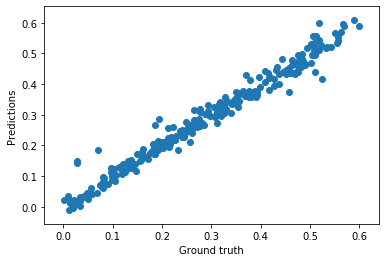

In [53]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [42]:
#%store model_rr_relative_swinging_x

In [43]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [44]:
# Save model
#joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

### Predict RR foot -> y

In [54]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # Previous motion command
               X_motion_RR_swinging[:, 3:6], # Current motion command
               #X_motion_RR_swinging[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_RR_swinging[:, 6:8], # FL (x,y) position
               X_motion_RR_swinging[:, 9:11], # FR (x,y) position
               X_motion_RR_swinging[:, 12:14], # RL (x,y) position
               X_motion_RR_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.2689609372500992
RMSE:  0.005541788690801017
The lowest error is:  7.38703679828423e-06
The highest error is:  0.031385977275922725
The avg. error is:  0.004249166649712971


In [57]:
model_rr_relative_swinging_y.coef_

array([[-9.68396761e-04,  1.02348685e-16, -1.11022302e-16,
         6.15428461e-03, -2.22044605e-16,  1.11022302e-16,
         1.58101117e-01, -5.44408332e-01,  2.84881050e-02,
         5.56203805e-01, -4.63776740e-02,  2.41075975e-01,
        -2.55065105e-01, -7.60707747e-01]])

In [58]:
model_rr_relative_swinging_y.intercept_

array([-0.11239619])

Text(0, 0.5, 'Predictions')

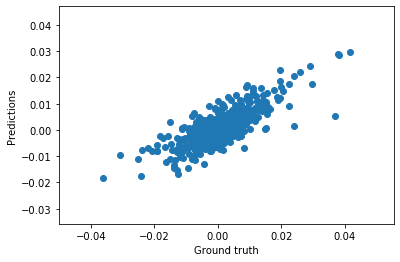

In [48]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [49]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')